In [99]:
import numpy as np
from stats import LinearSolveStats, TimeStepStats
from stats import TimeStepStats
from matplotlib import pyplot as plt
from plot_utils import *

data = load_data("../stats/fpm_1_open_solver_1.json")

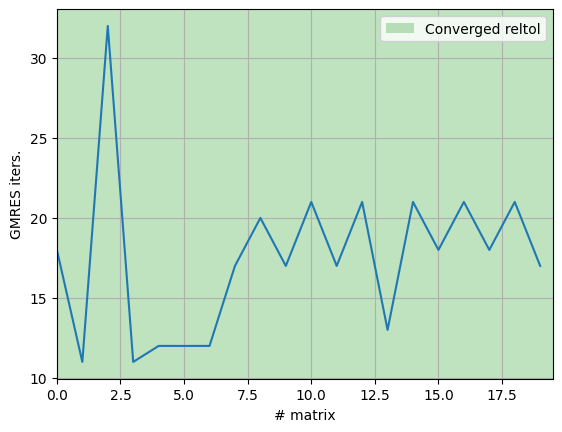

In [100]:
# %matplotlib ipympl
color_converged_reason(data)
plt.plot(get_gmres_iterations(data))
plt.ylabel('GMRES iters.')
plt.xlabel('# matrix')
# plt.yscale('log')
plt.legend()

In [101]:
# mat_idx = 14
mat_idx = 8
get_gmres_iterations(data)[mat_idx]

20

In [102]:
sticking, sliding, open = get_num_sticking_sliding_open(data)
print(sticking[mat_idx], sliding[mat_idx], open[mat_idx])

48 0 24


In [103]:
from plot_utils import *

mat, rhs = load_matrix_rhs(data, mat_idx)

In [104]:
import porepy as pp
import numpy as np
from mat_utils import *
from plot_utils import *
from fpm_1 import make_model
from pp_utils import make_row_col_dofs, make_reorder_contact

model = make_model()
model.prepare_simulation()

model.before_nonlinear_loop()
model.before_nonlinear_iteration()

model._initialize_solver()
eq_dofs, var_dofs = make_row_col_dofs(model)

reorder = make_reorder_contact(model)
mat = mat[reorder]

# model.assemble_linear_system()
# mat, rhs = model.linear_system
model.linear_system = mat, rhs
perm_mat, prec_orig = model._prepare_solver()

Solve  took: 0.4


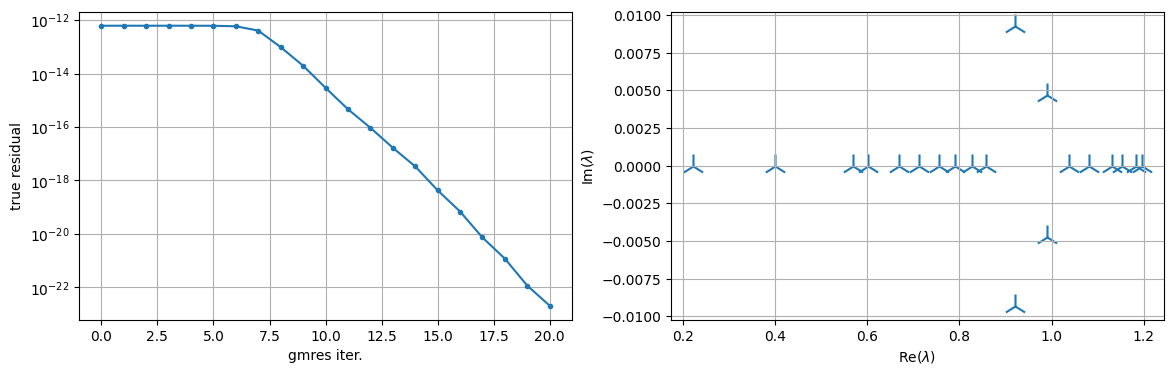

In [105]:
solve_petsc(perm_mat.mat, prec_orig, rhs=perm_mat.local_rhs(rhs))

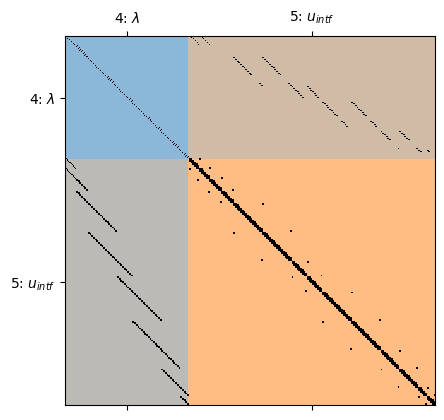

In [106]:
from block_matrix import BlockMatrixStorage
from pp_utils import correct_eq_groups

corrected_eq_dofs, corrected_eq_groups = correct_eq_groups(model)

J = BlockMatrixStorage(
    mat=mat,
    row_idx=corrected_eq_dofs,
    col_idx=model.var_dofs,
    groups_row=corrected_eq_groups,
    groups_col=model._variable_groups,
    group_row_names=[r'$p_{2D}$', r'$u_{2d}$', r'$p_{1D}$', r'$v_{intf}$', r'$\lambda$', '$u_{intf}$'],
    group_col_names=[r'$p_{2D}$', r'$u_{2d}$', r'$p_{1D}$', r'$v_{intf}$', r'$\lambda$', '$u_{intf}$']
)

J[[4, 5]].color_spy(True)

# J[:].color_spy()
# J[:].plot_max()
# J[:].matshow()

Solve  took: 0.13


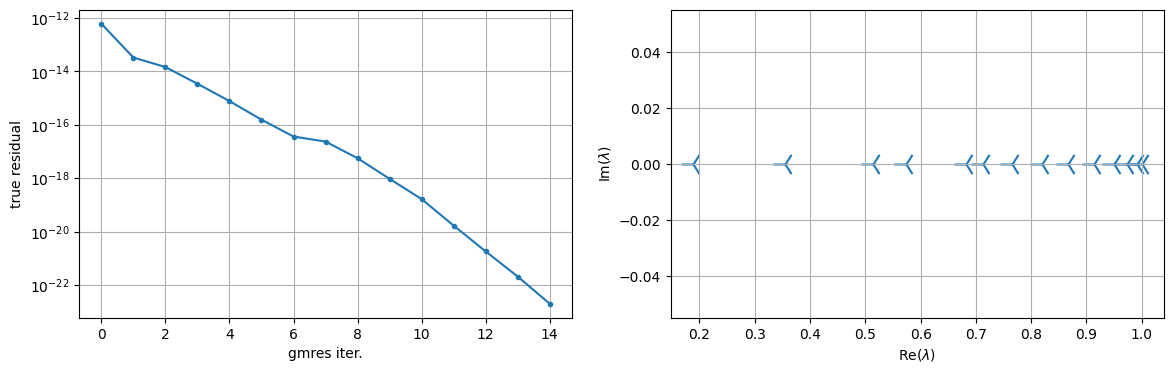

In [107]:
from block_matrix import SolveSchema, make_solver
from pp_utils import get_fixed_stress_stabilization

schema_1 = SolveSchema(
    groups=[1],
    solve=lambda bmat: PetscAMGMechanics(dim=model.nd, mat=bmat.mat),
)

schema_45_1 = SolveSchema(
    groups=[4, 5],
    complement=schema_1,
)

mat_permuted, prec = make_solver(schema=schema_45_1, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

Baseline lumping

Solve  took: 0.21


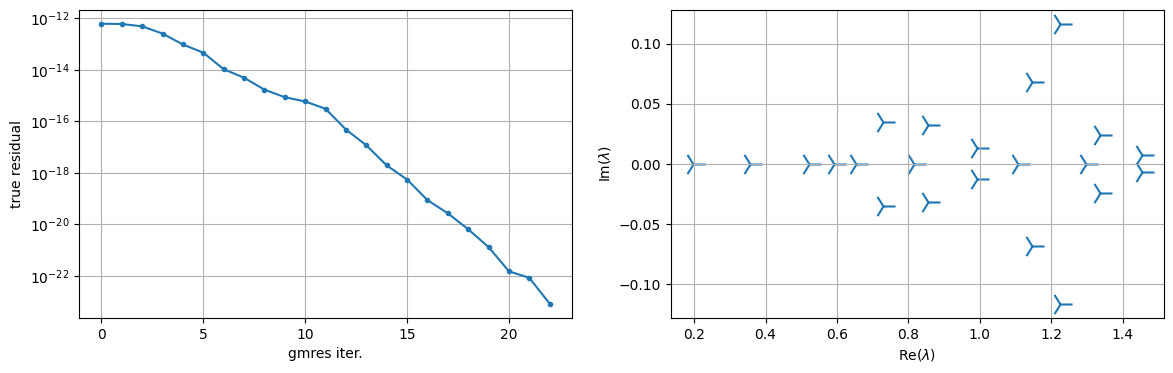

In [108]:
schema_5_4_1 = SolveSchema(
    groups=[5],
    # invertor=lambda bmat: inv_block_diag(bmat.mat, nd=model.nd),
    invertor=lambda bmat: inv_block_diag(lump_nd(bmat.mat, nd=model.nd), nd=model.nd),
    complement=SolveSchema(
        groups=[4],
        solve="use_invertor",
        invertor=lambda bmat: inv_block_diag(bmat.mat, nd=model.nd),
        complement=schema_1,
    ),
)

mat_permuted, prec = make_solver(schema=schema_5_4_1, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

Baseline lumping + 2 sides

Solve  took: 0.52


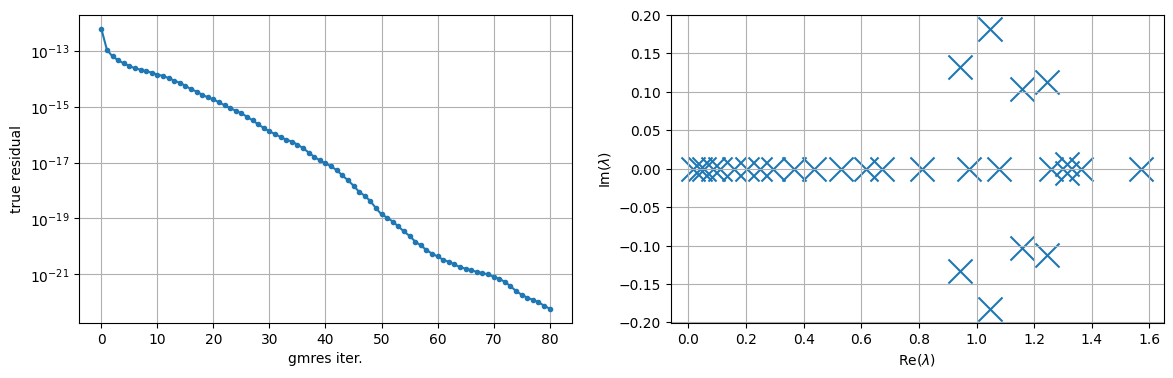

In [109]:
from preconditioner_mech import build_mechanics_stabilization

schema_45_1 = SolveSchema(
    groups=[4, 5],
    solve='direct',
    # solve=lambda bmat: build_mechanics_stabilization(model, bmat, lump=True, build_schur=False),
    # invertor=lambda x: scipy.sparse.eye(x.shape[0]),

    # only_complement=True,

    invertor=lambda: build_mechanics_stabilization(model, J, lump=True),
    invertor_type='physical',
    complement=schema_1,
)

mat_permuted, prec = make_solver(schema=schema_45_1, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

Just 2 sides

Solve  took: 0.46


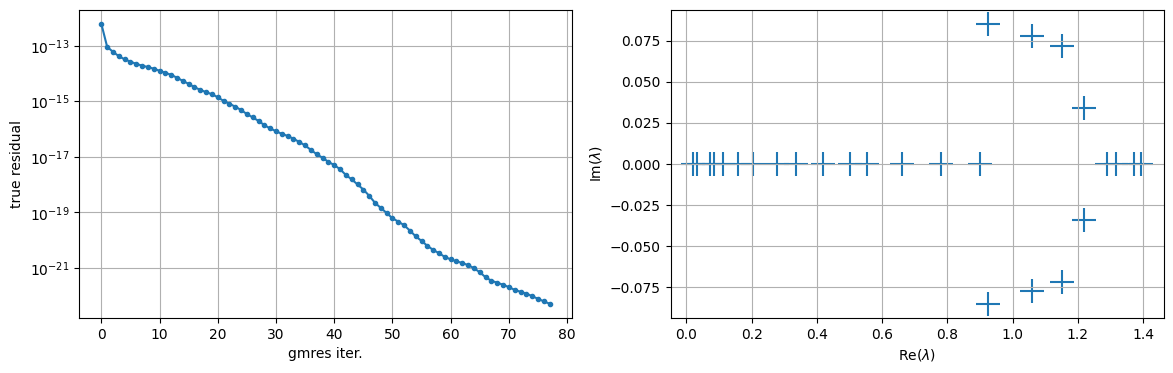

In [110]:
from preconditioner_mech import build_mechanics_stabilization

schema_45_1 = SolveSchema(
    groups=[4, 5],
    solve='direct',
    # solve=lambda bmat: build_mechanics_stabilization(model, bmat, lump=True, build_schur=False),
    # invertor=lambda x: scipy.sparse.eye(x.shape[0]),

    # only_complement=True,

    invertor=lambda: build_mechanics_stabilization(model, J, lump=False),
    invertor_type='physical',
    complement=schema_1,
)

mat_permuted, prec = make_solver(schema=schema_45_1, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

J45 only 2 sides 

Solve  took: 0.0


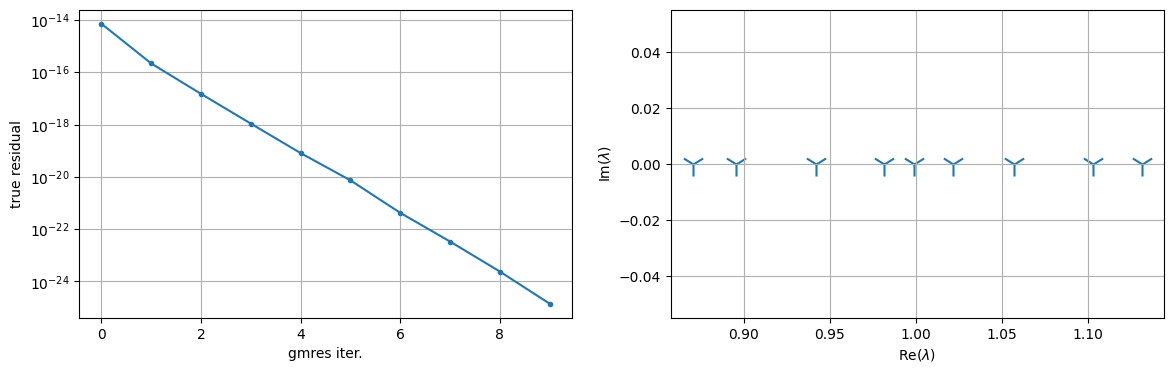

In [111]:
schema_45 = SolveSchema(
    groups=[4, 5],
    solve=lambda bmat: build_mechanics_stabilization(model=model, bmat=bmat, build_schur=False, lump=False),
)

mat_permuted, prec = make_solver(schema=schema_45, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

J45 only lumping 

Note: taking block diagonal is equivalent to the cell above.
Lumping is equivalent to lumping above

Solve  took: 0.0


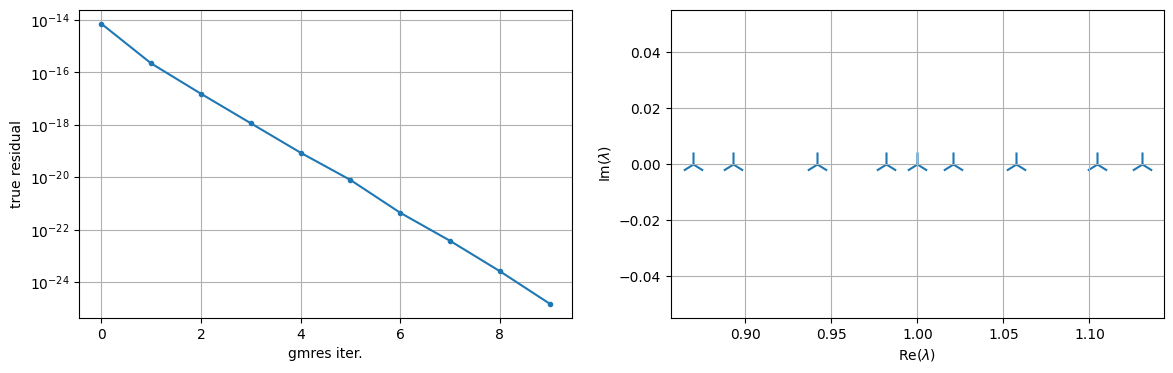

In [112]:
schema_5_4 = SolveSchema(
    groups=[5],
    solve='use_invertor',
    invertor=lambda bmat: inv_block_diag(bmat.mat, nd=model.nd),
    # invertor=lambda bmat: inv_block_diag(lump_nd(bmat.mat, nd=model.nd), nd=model.nd),

    complement=SolveSchema(
        groups=[4],
        solve='use_invertor',
        invertor=lambda bmat: inv_block_diag(bmat.mat, nd=model.nd),
    ),
)

mat_permuted, prec = make_solver(schema=schema_5_4, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

Lumping is equivalent with lumped 2 sides:

In [113]:
inv_2sides_lump = build_mechanics_stabilization(model=model, bmat=J, build_schur=False, lump=True)

tmp = J[[4,5]]
tmp[5, 5] = lump_nd(tmp[5, 5].mat, nd=model.nd)

inv_lump55 = inv(tmp.mat)

cond(inv(inv_2sides_lump) @ inv_lump55)

1.000000000000062

Diagonal is equivalent with 2 sides:

In [114]:
inv_2sides = build_mechanics_stabilization(model=model, bmat=J, build_schur=False, lump=False)

tmp = J[[4,5]]
tmp[5, 5] = diag_nd(tmp[5, 5].mat, nd=model.nd)

inv_diag55 = inv(tmp.mat)

cond(inv(inv_2sides) @ inv_diag55)

1.076521315358473

Diagonal schur S11:

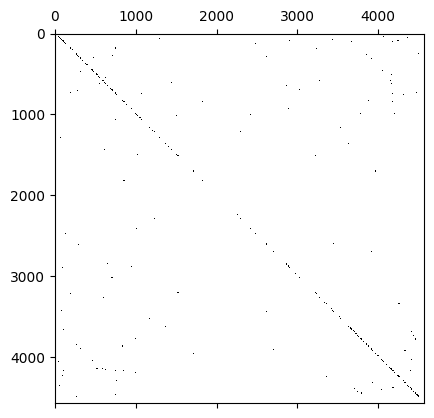

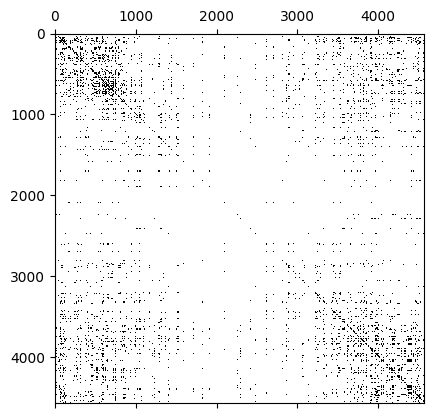

In [115]:
stab_11_2sides = build_mechanics_stabilization(model=model, bmat=J, build_schur=True, lump=False)

stab_11_diag = J[1, [4,5]].mat @ inv_diag55 @ J[[4, 5], 1].mat

spy(stab_11_2sides)
spy(stab_11_diag)

/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/home/porepy/simulations/plot_utils.py:102: RuntimeWarning: divide by zero encountered in log10
  mat = np.log10(abs(mat))


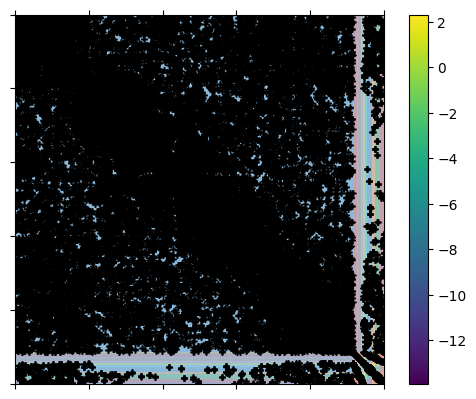

In [120]:
# %matplotlib tk

from porepy.numerics.linalg.matrix_operations import sparse_kronecker_product

fractures = model.mdg.subdomains(dim=model.nd - 1)

tmp = J[[1,4,5]]
J_51 = J[5, 1]
tmp[[4, 5]] = build_mechanics_stabilization(model, J, build_schur=False)

tmp.color_spy(groups=False, show=False, aspect='auto', marker='+')
tmp.matshow(log=True, show=False)


for frac_idx, frac in enumerate(fractures):
    if frac_idx != 0:
        continue
    intfs = model.mdg.subdomain_to_interfaces(sd=frac)
    for intf in intfs:
        if intf.dim < frac.dim:
            continue
        matrix = model.mdg.interface_to_subdomain_pair(intf=intf)[0]
        assert matrix.dim == model.nd

        secondary_to_mortar = intf.secondary_to_mortar_avg(nd=model.nd).tocsc()
        mortar_to_primary = intf.mortar_to_primary_avg(nd=model.nd).tocsc()
        faces_to_cells = sparse_kronecker_product(
            matrix.cell_faces.T, nd=model.nd
        ).tocsc()
        secondary_to_mortar.eliminate_zeros()
        mortar_to_primary.eliminate_zeros()
        faces_to_cells.eliminate_zeros()

        frac_to_mat_cells = faces_to_cells @ mortar_to_primary @ secondary_to_mortar

        for frac_cell_id in range(frac.num_cells):
            if frac_cell_id != 8:
            # if frac_cell_id % 10 != 0:
                continue

            frac_cells = frac_cell_id * model.nd + np.arange(model.nd)
            intf_cells = secondary_to_mortar[:, frac_cells].indices
            mat_cells = frac_to_mat_cells[:, frac_cells].indices

            row_idx, col_idx = tmp.get_global_indices([intf_cells, intf_cells], group=(5, 5), subgroup=(frac_idx, frac_idx))
            for x in col_idx:
                for y in row_idx:
                    plt.scatter(x, y, color='r', marker='x', alpha=0.9)

            row_idx, col_idx = tmp.get_global_indices([frac_cells, intf_cells], group=(4, 5), subgroup=(frac_idx, frac_idx))
            for x in col_idx:
                for y in row_idx:
                    plt.scatter(x, y, color='r', marker='x', alpha=0.9)

            row_idx, col_idx = tmp.get_global_indices([frac_cells, frac_cells], group=(4, 4), subgroup=(frac_idx, frac_idx))
            for x in col_idx:
                for y in row_idx:
                    plt.scatter(x, y, color='r', marker='x', alpha=0.9)

            row_idx, col_idx = tmp.get_global_indices([intf_cells, frac_cells], group=(5, 4), subgroup=(frac_idx, frac_idx))
            for x in col_idx:
                for y in row_idx:
                    plt.scatter(x, y, color='r', marker='x', alpha=0.9)

            row_idx, col_idx = tmp.get_global_indices([intf_cells, mat_cells], group=(5, 1), subgroup=(frac_idx, 0))
            for x in col_idx:
                for y in row_idx:
                    plt.scatter(x, y, color='r', marker='x', alpha=0.9)

            row_idx, col_idx = tmp.get_global_indices([mat_cells, intf_cells], group=(1, 5), subgroup=(0, frac_idx))
            for x in col_idx:
                for y in row_idx:
                    plt.scatter(x, y, color='r', marker='x', alpha=0.9)

            row_idx, col_idx = J_51.get_global_indices([intf_cells, mat_cells], group=(5, 1), subgroup=(frac_idx, 0))
            x = J_51.mat[row_idx]
            # assert x[:, col_idx].nnz == 18

plt.show()

# Lumping

Solve  took: 0.46


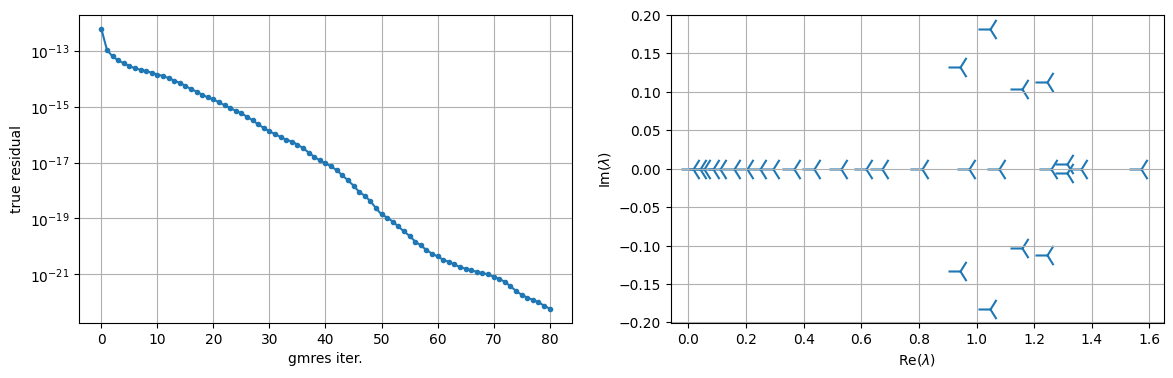

In [117]:
schema_45_1 = SolveSchema(
    groups=[4, 5],
    solve='direct',
    # invertor=lambda x: scipy.sparse.eye(x.shape[0]),

    invertor=lambda: build_mechanics_stabilization(model, J, lump=True),
    invertor_type='physical',
    complement=schema_1,
)

mat_permuted, prec = make_solver(schema=schema_45_1, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

Solve  took: 0.0


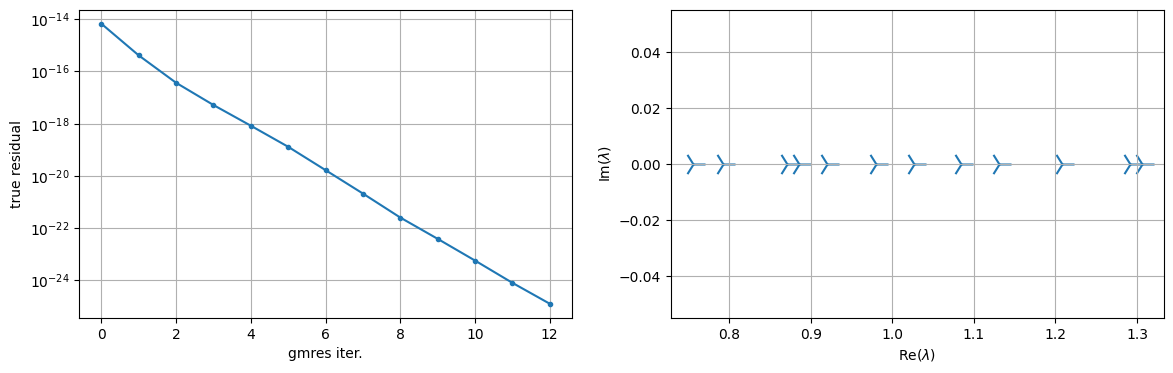

In [118]:
schema_5_4 = SolveSchema(
    groups=[5],
    solve='use_invertor',
    # invertor=lambda bmat: extract_diag_inv(bmat.mat),
    # invertor=lambda bmat: extract_rowsum_inv(bmat.mat),
    # invertor=lambda bmat: extract_rowsum_inv(abs(bmat.mat)) / 6,
    # invertor=lambda bmat: inv_block_diag_2x2(bmat.mat),
    invertor=lambda bmat: inv_block_diag(lump_nd(bmat.mat, nd=model.nd), nd=model.nd),


    # complement=SolveSchema(
    #     groups=[4],
    #     # solve=lambda bmat: inv_block_diag_2x2(bmat.mat),
    #     solve=lambda bmat: inv_block_diag(bmat.mat, nd=model.nd),
    # )
)

mat_permuted, prec = make_solver(schema=schema_5_4, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

In [119]:
J55 = J[[5]]

def build_lumped_J55(J55: BlockMatrixStorage):
    bmats = []  
    for i in range(len(J55.active_subgroups[0])):
        row = []
        for j in range(len(J55.active_subgroups[1])):
            row.append(lump_nd(J55.slice_domain(i, j), nd=model.nd))
        bmats.append(row)

    return bmat(bmats)


J45_lumped = J[[4,5]]
J45_lumped[5, 5] = build_lumped_J55(J[[5]])

# solve_petsc(J55.mat, inv(tmp), rhs=J55.local_rhs(rhs)); plt.show()
solve_petsc(J[[4, 5]].mat, build_mechanics_stabilization(model=model, bmat=J45_lumped, build_schur=False), rhs=J[[4, 5]].local_rhs(rhs)); plt.show()


# spy(inv(tmp))


IndexError: index (22) out of range

Solve  took: 0.0


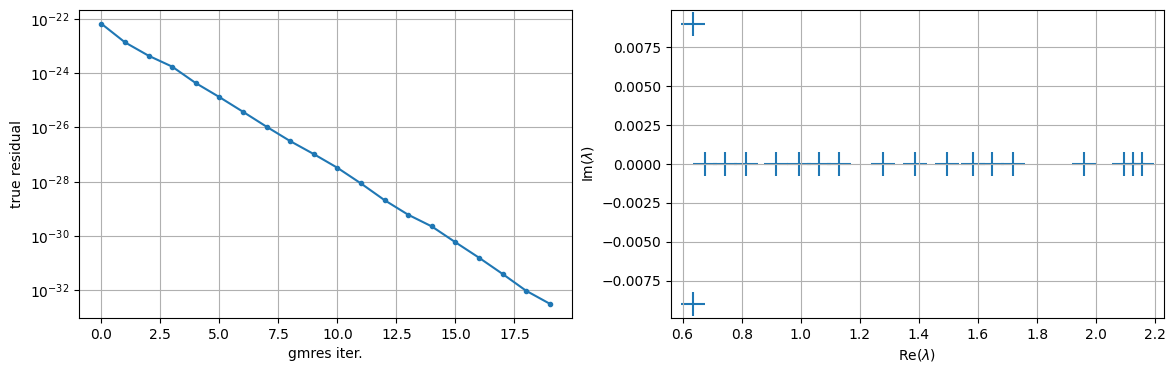

In [ ]:
J55 = J[[5]]

def build_lumped_J55_v2(J55: BlockMatrixStorage):
    active_subgroups = J55.active_subgroups
    shape = len(active_subgroups[0]) * 2, len(active_subgroups[1]) * 2
    bmats = np.ndarray(shape, dtype=object)

    for i in range(len(active_subgroups[0])):
        for j in range(len(active_subgroups[1])):
            block = J55.slice_domain(i, j)
            mid = block.shape[0] // 2
            if True:
                b00 = lump_nd(block[:mid, :mid], nd=model.nd)
                b01 = lump_nd(block[:mid, mid:], nd=model.nd)
                b10 = lump_nd(block[mid:, :mid], nd=model.nd)
                b11 = lump_nd(block[mid:, mid:], nd=model.nd)
            else:
                b00 = block[:mid, :mid]
                b01 = block[:mid, mid:]
                b10 = block[mid:, :mid]
                b11 = block[mid:, mid:]
            bmats[2 * i, 2 * j] = b00
            bmats[2 * i, 2 * j + 1] = b01
            bmats[2 * i + 1, 2 * j] = b10
            bmats[2 * i + 1, 2 * j + 1] = b11

    return bmat(bmats)


J45_lumped = J[[1, 4,5]]
J45_lumped[5, 5] = build_lumped_J55_v2(J[[5]])

# solve_petsc(J55.mat, inv(tmp), rhs=J55.local_rhs(rhs)); plt.show()
solve_petsc(J[[4, 5]].mat, build_mechanics_stabilization(model=model, bmat=J45_lumped, build_schur=False), rhs=J[[4, 5]].local_rhs(rhs)); plt.show()


# spy(inv(tmp))


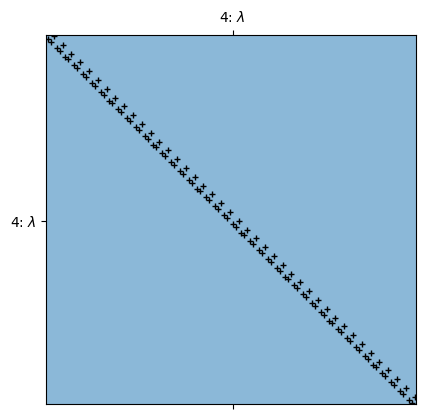

Solve  took: 0.11


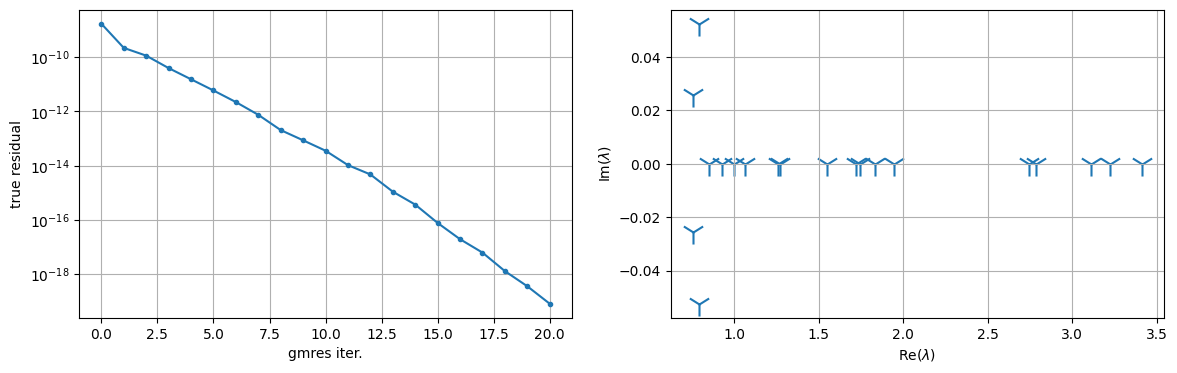

In [ ]:
schema_5_4_1 = SolveSchema(
    groups=[5],
    solve='direct',
    invertor=lambda bmat: inv(build_lumped_J55(bmat[[5, 5]])),
    complement=SolveSchema(
        color_spy=True,
        groups=[4],
        solve='direct',
        invertor=lambda bmat: inv_block_diag(bmat.mat, nd=model.nd),
        complement=schema_1,
    ),
)

mat_permuted, prec = make_solver(schema=schema_5_4_1, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

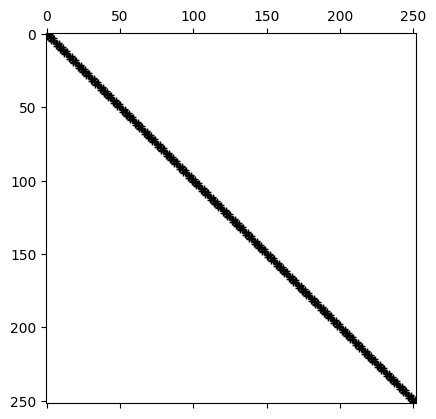

In [ ]:
spy(build_lumped_J55(J[[5, 5]]))